# Laboratorio 3: Word Embeddings

- Profesores: [Andrés Abeliuk](https://aabeliuk.github.io/), [Fabián Villena](https://villena.cl/).
- Profesor Auxiliar: [Martín Paredes](https://github.com/MartinParedesR/)


In [1]:
!pip install datasets
!pip install gensim


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import datasets
import numpy as np
import pandas as pd
# import spacy.lang.es
import matplotlib.pyplot as plt
import sklearn.pipeline
import sklearn.feature_extraction

# Word Embeddings: Word2Vec

### El gran problema de Bag of Words

Pensemos en estas 3 frases como documentos:

- $doc_1$: `¡Buenísima la marraqueta!`
- $doc_2$: `¡Estuvo espectacular ese pan francés!`
- $doc_3$: `!Buenísima esa pintura!`

Sabemos $doc_1$ y $doc_2$ hablan de lo mismo y que $doc_3$  no tiene mucho que ver con los otros.

**¿Cuál es el problema?**

`buenísima` $\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \\ 0 \\0\end{bmatrix}$ y `espectacular` $ \begin{bmatrix}0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0\end{bmatrix}$ representan ideas muy similares. Por otra parte, sabemos que `marraqueta` $\begin{bmatrix}0 \\ 1 \\ 0 \\ 0 \\ 0 \\0\end{bmatrix}$ y `pan francés` $\begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 1 \\0\end{bmatrix}$ se refieren al mismo objeto. Pero en este modelo, estos **son totalmente distintos**. Es decir, los vectores de las palabras que `buenísima` y `espectacular` son tan distintas como `marraqueta` y `pan francés`. Esto se debe a que cada palabra ocupa una dimensión distinta a las demás y son completamente independientes. Esto evidentemente, repercute en la calidad de los modelos que creamos a partir de nuestro Bag of Words.

Nos gustaría que eso no sucediera. Que existiera algún método que nos permitiera hacer que palabras similares tengan representaciones similares

### **Word Embeddings**

Es una de las representaciones más populares del vocabulario de un corpus. La idea principal de los Word Embeddings es crear representaciones vectoriales densas y de baja dimensionalidad $(d << |V|)$ de las palabras a partir de su contexto.

Volvamos a nuestro ejemplo anterior: `buenísima` y `espectacular` ocurren muchas veces en el mismo contexto, por lo que los embeddings que los representan debiesen ser muy similares... (*ejemplos de mentira hechos a mano*):

`buenísima` $\begin{bmatrix}0.32 \\ 0.44 \\ 0.92 \\ .001 \end{bmatrix}$ y `espectacular` $\begin{bmatrix}0.30 \\ 0.50 \\ 0.92 \\ .002 \end{bmatrix}$ versus `marraqueta`  $\begin{bmatrix}0.77 \\ 0.99 \\ 0.004 \\ .1 \end{bmatrix}$ el cuál es claramente distinto.

## **Entrenar nuestros Embeddings**

Para entrenar nuestros embeddings, usaremos el paquete gensim. Este trae una muy buena implementación de `word2vec`.




In [3]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import string
import multiprocessing
import os
import requests
import numpy as np

# word2vec
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# visualizaciones
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets

In [11]:
# Obtener stopwords en español

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stopwords_es = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mbustamc/nltk_data...
[nltk_data] Error downloading 'stopwords' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/corpora/stopwords.zip>:   HTTP Error
[nltk_data]     429: Too Many Requests


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/mbustamc/nltk_data'
    - '/home/mbustamc/Documentos/diplomados/dia_2025/CC66Q/.venv/nltk_data'
    - '/home/mbustamc/Documentos/diplomados/dia_2025/CC66Q/.venv/share/nltk_data'
    - '/home/mbustamc/Documentos/diplomados/dia_2025/CC66Q/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


### Cargar el dataset y limpiar

Utilizaremos un datos de diversas fuentes de noticias que cuenta con tres atributos principales:

* texto: Referente al texto de la noticia.
* medio: Referente al medio de la noticia.
* fecha: Referente a la fecha de publicación.

In [12]:
dataset = pd.read_csv('https://raw.githubusercontent.com/giturra/JCC2023-WE/main/noticias_oct_dic_2019.tsv', sep='\t')

dataset.head()

HTTPError: HTTP Error 429: Too Many Requests

In [14]:
import pickle 
dataset = pd.read_pickle('dataset.pkl')

In [ ]:
dataset.medio.unique()

In [ ]:
from collections import Counter

# limpiar puntuaciones y separar por tokens.
punctuation = string.punctuation + "«»“”‘’…—"
stopwords = stopwords_es

def simple_tokenizer(doc, lower=False):
    if lower:
        tokenized_doc = doc.translate(str.maketrans(
            '', '', punctuation)).lower().split()

    tokenized_doc = doc.translate(str.maketrans('', '', punctuation)).split()
    tokenized_doc = [
        token for token in tokenized_doc if token.lower() not in stopwords
    ]
    return tokenized_doc

content = dataset['texto']
cleaned_content = [simple_tokenizer(doc,lower=True) for doc in content.values]

In [ ]:
dataset.texto[10]

In [ ]:
print("Ejemplo de alguna noticia: {}".format(cleaned_content[10]))
# print("noticia original: {}".format(content[10]))

### Extracción de Frases

Para crear buenas representaciones, es necesario tambien encontrar conjuntos de palabras que por si solas no tengan mayor significado (como `nueva` y `york`), pero que juntas que representen ideas concretas (`nueva york`).

Para esto, usaremos el primer conjunto de herramientas de `gensim`: `Phrases` y `Phraser`.

In [ ]:
# Phrases recibe una lista de oraciones, y junta bigramas que estén al menos 100 veces repetidos
# como un único token. Detrás de esto hay un modelo estadístico basado en frecuencias, probabilidades, etc
# pero en términos simples ese es el resultado

phrases = Phrases(cleaned_content, min_count=100)

In [ ]:
def top_bigrams_from_phrases(phrases, top=20):
    """
    Extrae los bigramas aprendidos por gensim.models.Phrases
    y los retorna ordenados por frecuencia (desc).
    """
    bigrams = {}
    for k, v in phrases.vocab.items():
        # Filtra verdaderos bigramas (contienen al menos un "_" )
        # y evita tokens vacíos/raros
        if "_" in k and len(k) > 1:
            bigrams[k] = v

    # Ordena por frecuencia descendente
    return sorted(bigrams.items(), key=lambda x: -x[1])[:top]

# Uso:
tops = top_bigrams_from_phrases(phrases, top=20)
for bg, freq in tops:
    print(bg, freq)


Ahora, usamos `Phraser` para re-tokenizamos el corpus con los bigramas encontrados. Es decir, juntamos los tokens separados que detectamos como frases.

In [ ]:
bigram = Phraser(phrases)
sentences = bigram[cleaned_content]

In [ ]:
sentences[2]

### Ejercicio 1: Definir el modelo



Primero, como es usual, creamos el modelo. En este caso, usaremos uno de los primero modelos de embeddings neuronales: `word2vec`

Algunos parámetros importantes:

- `min_count`: Ignora todas las palabras que tengan frecuencia menor a la indicada.
- `window` : Tamaño de la ventana. Usaremos 4.
- `size` : El tamaño de los embeddings que crearemos. Por lo general, el rendimiento sube cuando se usan mas dimensiones, pero después de 300 ya no se nota cambio. Ahora, usaremos solo 200.
- `(Recomendable) workers`: Cantidad de CPU que serán utilizadas en el entrenamiento.

In [ ]:
#Programe aquí
w2v = ...

### Construir el vocabulario

Para esto, se creará un conjunto que contendrá (una sola vez) todas aquellas palabras que aparecen mas de `min_count` veces.

In [ ]:
w2v.build_vocab(sentences, progress_per=10000)

### Ejercicio 2: Entrenar el Modelo

A continuación, entenaremos el modelo.
Los parámetros que usaremos serán:

- `total_examples`: Número de documentos.
- `epochs`: Número de veces que se iterará sobre el corpus.

Es recomendable que tengan instalado `cpython` antes de continuar. Aumenta bastante la velocidad de entrenamiento.


In [ ]:
# Programe aquí

###  Guardar y cargar el modelo

Para ahorrar tiempo (o se espera que se entrene el modelo), usaremos un modelo preentrenado.

In [ ]:
kv = w2v.wv
kv.save("w2v.kv")
kv = KeyedVectors.load("w2v.kv", mmap='r')  # mapea a disco, menos RAM
kv.fill_norms()  # opcional, acelera similarity/most_similar

### Ejercicio 3: Analogías

Encuentre las palabras mas similares a: perro, Chile y Colo_Colo

In [ ]:
#Programe aquí

Por otra parte, la analogía consiste en comparar 3 terminos mediante una operación del estilo:

$$palabra1 - palabra2 \approx palabra 3 - x$$

para encontrar relaciones entre estos.

Por ejemplo: **Sol** es a **Día** como **Luna** es a **x**.

Lo cual se puede representar de esta forma:

| palabra 1 (pos) |  palabra 2 (neg) |
|-----------------|------------------|
|  Sol          | Día         |
| Luna           |  x               |

En donde **x** corresponde a **Noche**.

Usando el modelo entrenado encuentre la respuesta a las siguientes analogías:

- Brasil es a Bolsonaro como Argentina es a **?**
- Santiago es a Chile como Buenos Aires es a **?**

In [ ]:
#Programe aquí

### Ejercicio 4: Visualizar

Para visualizar usaremos las 1000 palabras más comunes y reduciremos las 200 dimensiones a 2. Para esto, grafique un [`T-SNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
#Programe aquí

Se espera que el gráfico tenga esta forma:

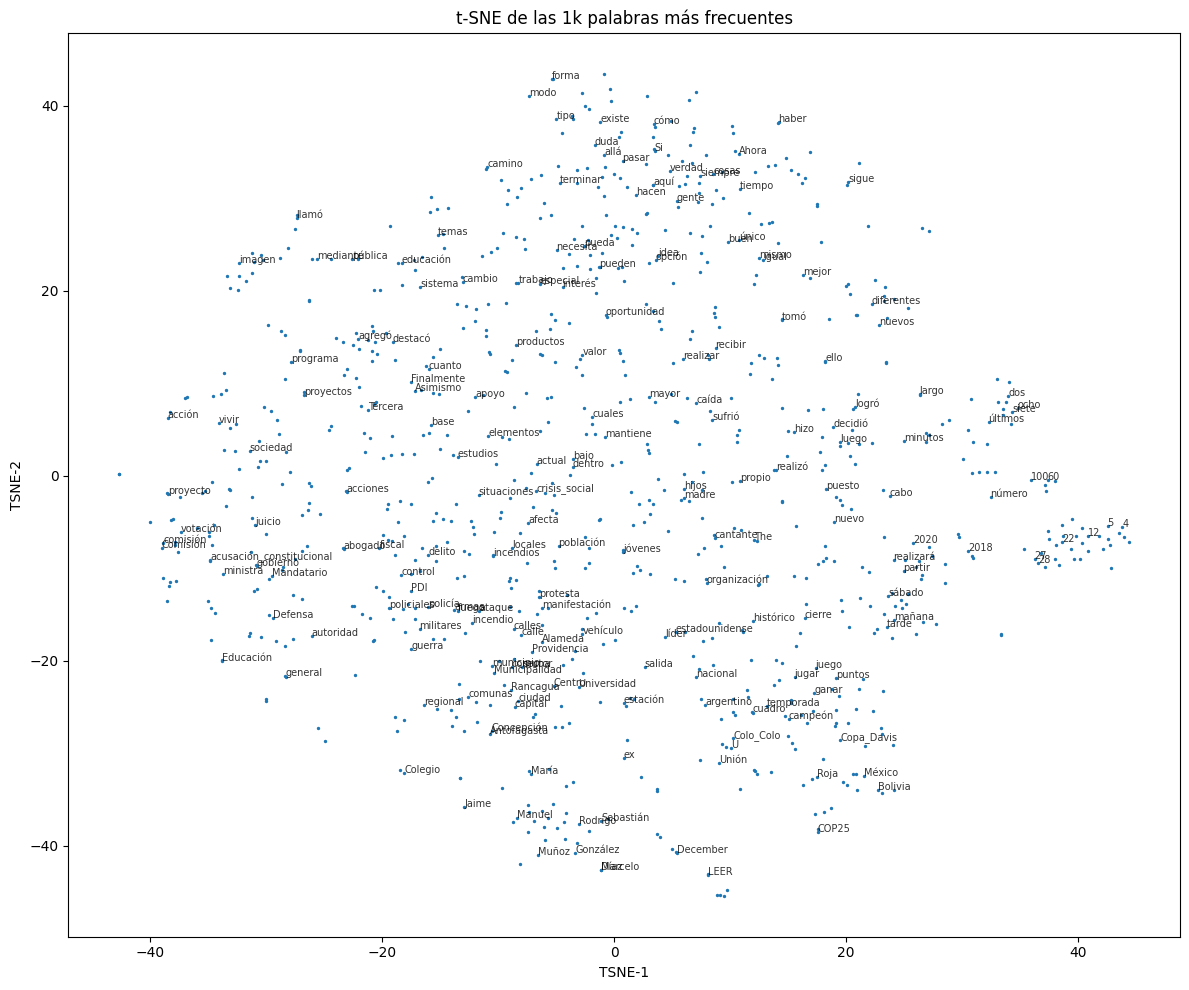

## **Ejercicio 5: Word Embeddings como características para recuperación semántica**


En esta sección usaremos word embeddings como representación para recuperar noticias por significado (no solo por palabras exactas). La idea es convertir tanto las consultas como las noticias en vectores y buscar por similitud en ese espacio.
Ejemplo: si el usuario escribe “deporte”, la búsqueda semántica también podrá traer artículos titulados “Liga profesional”, “Final del torneo”, “Selección nacional” o “Atleta olímpico clasifica”, aunque no contengan literalmente la palabra “deporte”.

El objetivo de esta sección es comparar como afectan distintas representaciones de texto a la hora de realizar recuperación semántica.

Para realizar la recuperación semántica programe la función que se muestra a continuación, la obtiene el **vector promedio** de las representaciones de la palabra en un documento.

Luego obtenga diferentes representaciones del texto usando tf-idf y word2vec. Con ambas representaciones Compare los top-k documentos más similares a la query del texto **deporte** usando la función entregada y luego compare. ¿Cómo difieren los top-k documentos entre sí? ¿Por qué? ¿Cómo afecta el uso de distintos embeddings para un mismo problema?


### Promedio simple de representación de texto

In [ ]:
def doc_embed_mean(tokens, kv):
    pass

### Dividir el dataset en training y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.texto,
                                                    dataset.medio,
                                                    test_size=0.33,
                                                    random_state=42)

#### Obtener representaciones del texto tf-idf y word2vec

In [ ]:
# Programe aquí

#### Obtener top-k documentos más similares

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_top_k_embeddings(query, D_matrix, original_texts, tfidf_vectorizer, kv_model, k=5):
    """
    Devuelve top-k documentos más similares a la query usando coseno
    con embeddings ponderados por TF-IDF.
    """
    pass

In [ ]:
#Programe aquí

query = "deporte"

### Propuesto...

- Usar su modelo de embeddings favorito para ver si mejora el retrieval:
    
 - Fast y word2vec en español, [cortesía](https://github.com/dccuchile/spanish-word-embeddings) de los grandes del DCC

 - hacer un clasificador de noticias para predecir de que medio es

- Visualizar los documentos usando `doc2vec`